In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'lapa_replication_rate',
        root = '..',
        default_wildcards={'site': 'tes'}
    )

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from lapa.result import LapaTssResult, LapaResult

In [3]:
df_lr = snakemake.params['df_lr']

In [4]:
site = snakemake.wildcards['site']

In [5]:
if site == 'tss':
    lapa = LapaTssResult(snakemake.input['lapa_dir'], replicated=False)
elif site == 'tes':
    lapa = LapaResult(snakemake.input['lapa_dir'], replicated=False)
else:
    raise ValueError(f'Site need to be either tss or tes but got {site}')

In [6]:
def get_biosample(dataset):
    return  df_lr[df_lr['Experiment accession'] == dataset].iloc[0]['sample']

def get_samples(dataset):
    return df_lr[df_lr['Experiment accession'] == dataset].index.tolist()

In [7]:
df_thresholds = list()

for dataset in tqdm(lapa.datasets):
    biosample = get_biosample(dataset)

    df_thresholds.append({
        'experiment': dataset,
        'biosample': biosample,
        'threshold': lapa.read_dataset(dataset)['count'].min(),
        'num_replicates': len(get_samples(dataset))
    })
    
df_thresholds = pd.DataFrame(df_thresholds)

  0%|          | 0/95 [00:00<?, ?it/s]

In [8]:
df_thresholds.to_csv(snakemake.output['table_threshold'], index=False)

In [9]:
df_thresholds = df_thresholds[df_thresholds['num_replicates'] > 1]

In [10]:
df_thresholds['threshold'].min()

3

In [11]:
df_thresholds['threshold'].max()

18

In [12]:
df_thresholds['threshold'].mean()

7.083333333333333

In [13]:
df_thresholds['threshold'].median()

7.0

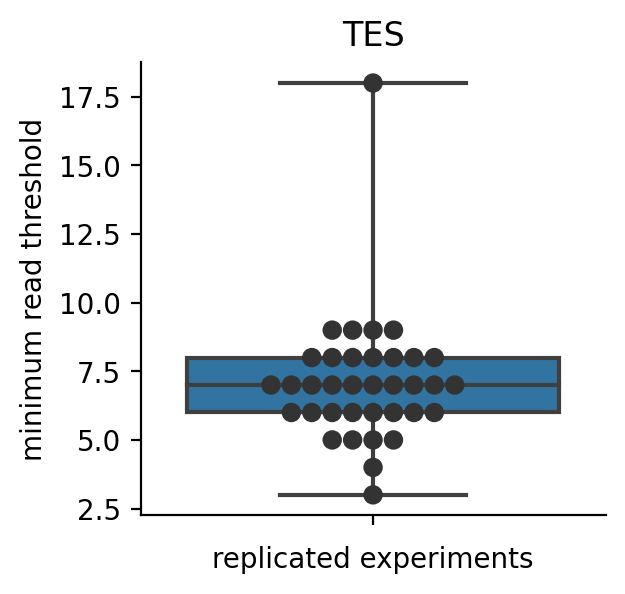

In [14]:
plt.figure(figsize=(3, 3), dpi=200)
sns.boxplot(data=df_thresholds, y='threshold', whis=np.inf)

sns.swarmplot(data=df_thresholds, color=".2", y='threshold', hue='experiment', s=7)
sns.despine()
plt.ylabel('minimum read threshold')
plt.xlabel('replicated experiments')

plt.title(site.upper())
plt.savefig(snakemake.output['fig_threshold'], bbox_inches = "tight")

  0%|          | 0/95 [00:00<?, ?it/s]

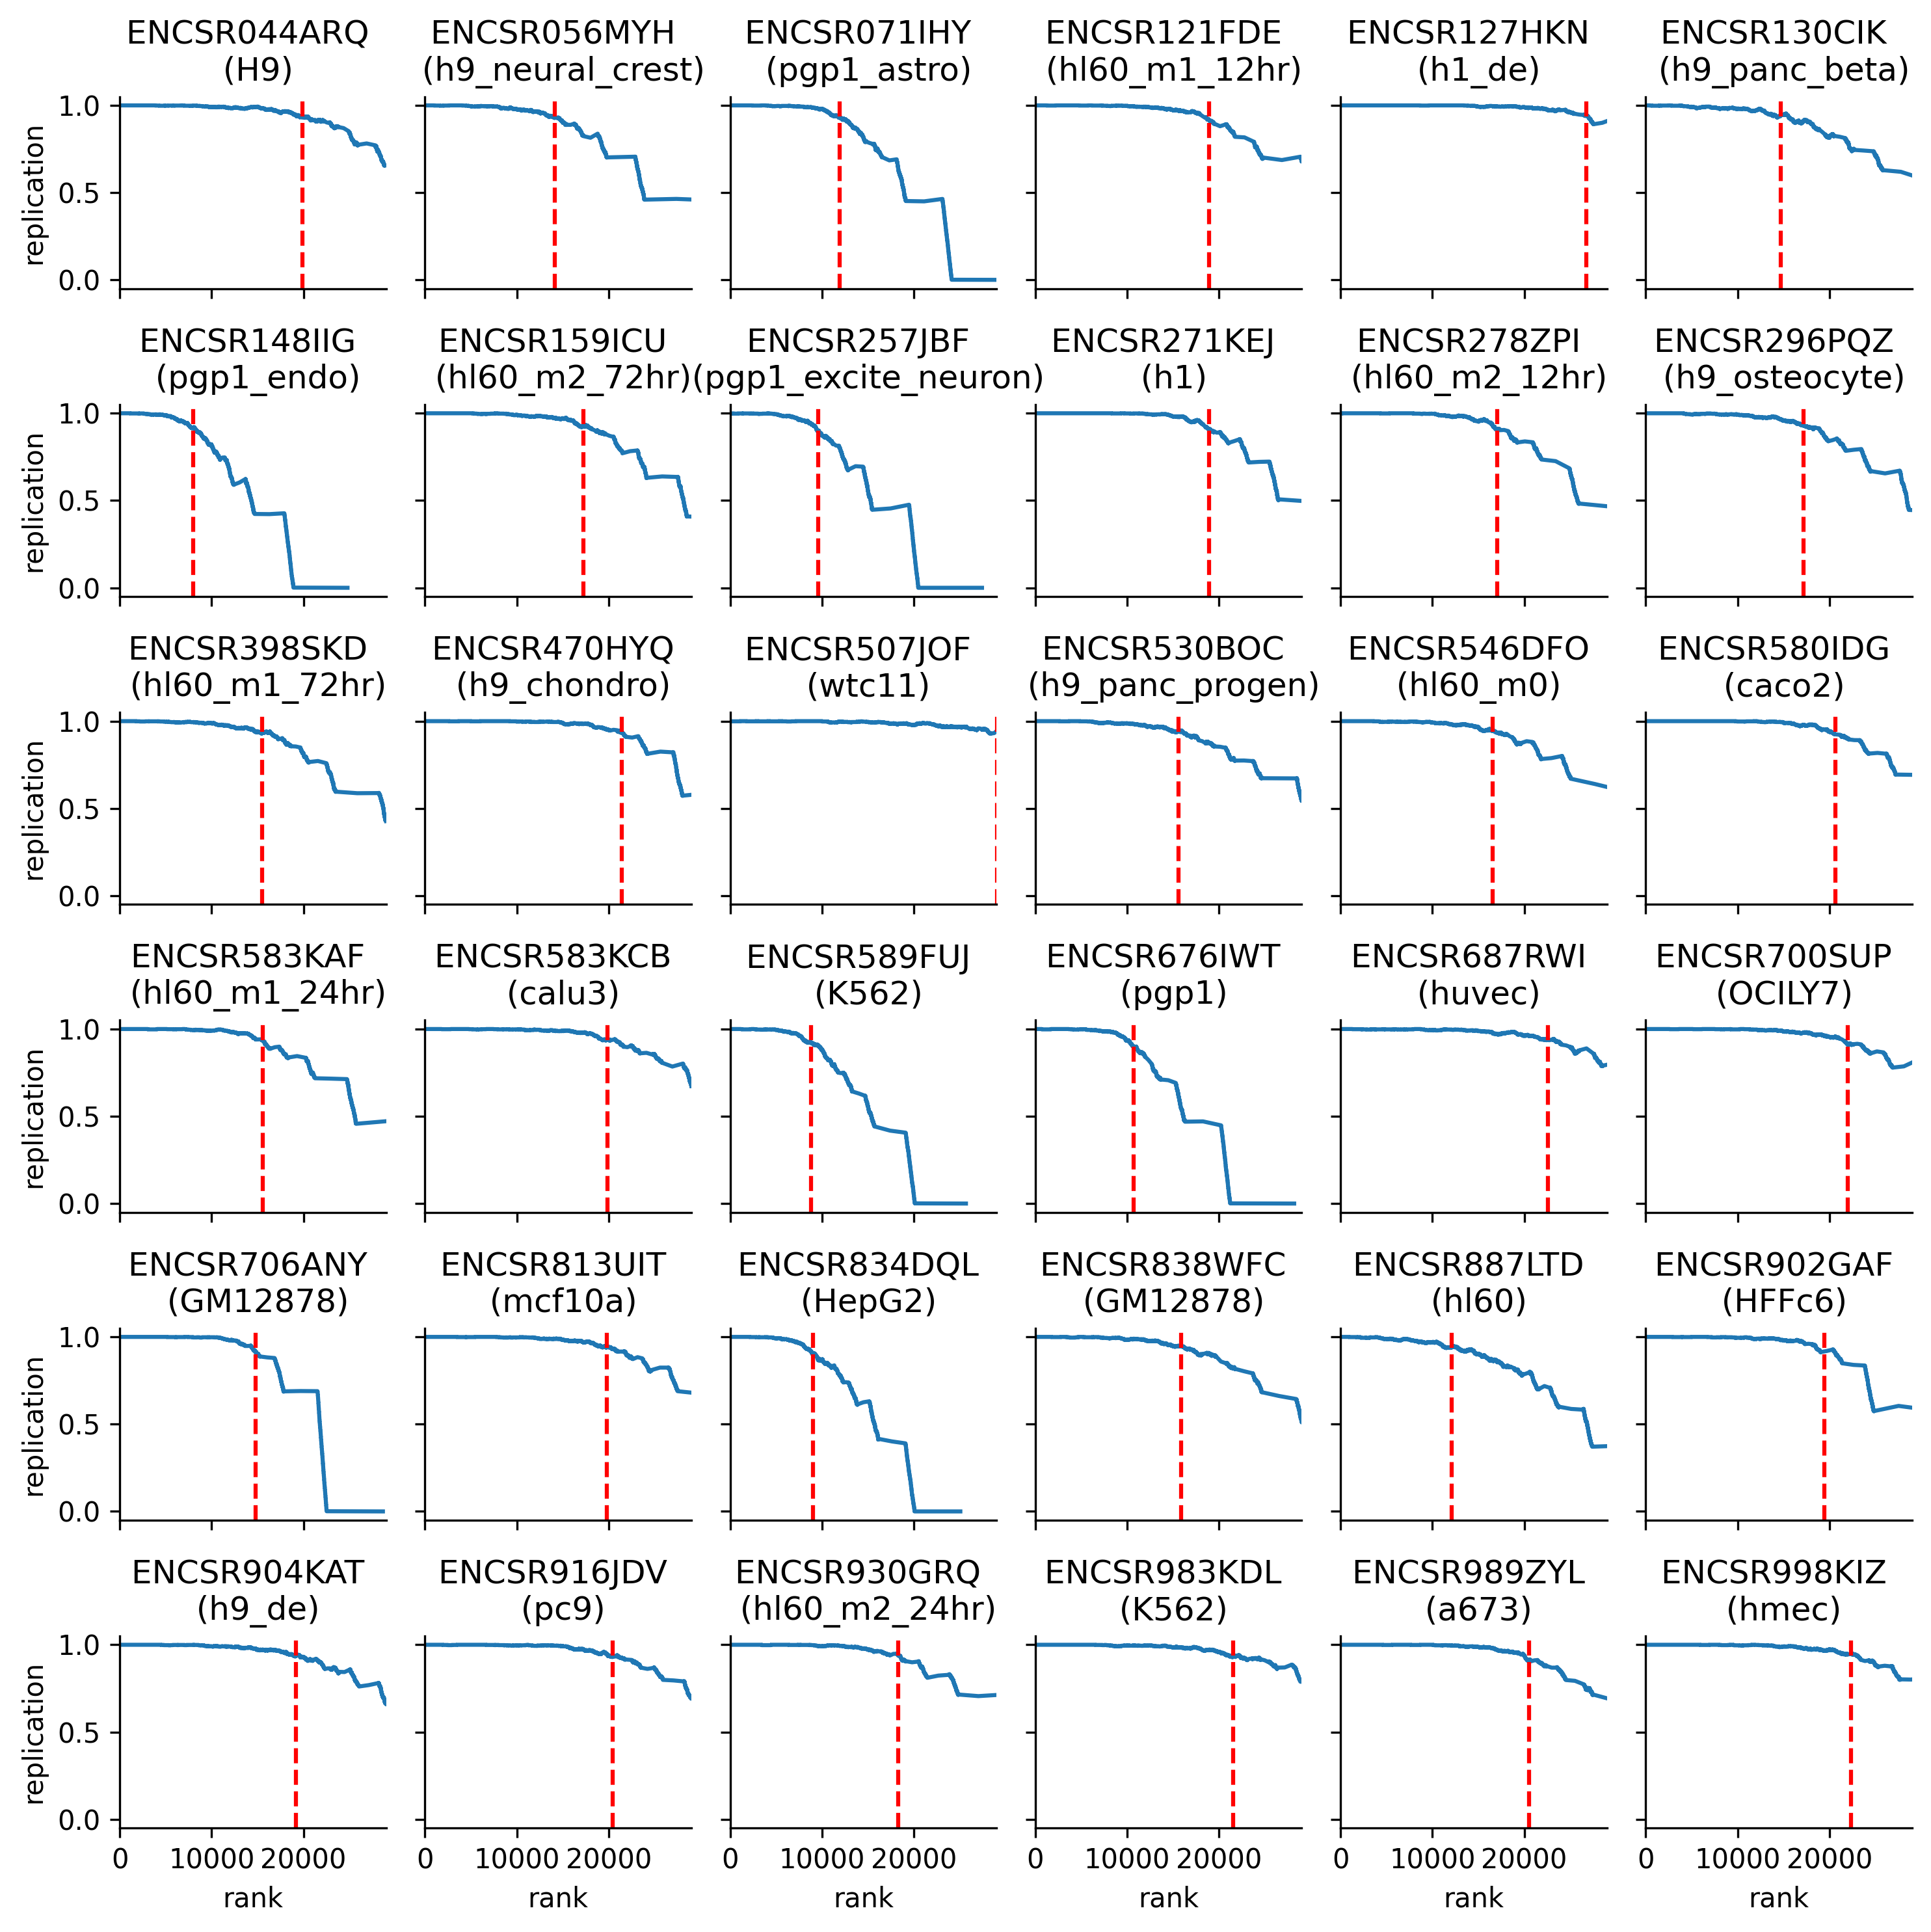

In [16]:
from more_itertools import flatten

_core_cols = ['Chromosome', 'Start', 'End', 'Strand']

n = 0

fig, axs = plt.subplots(6, 6, dpi=300, figsize=(10, 10), sharey=True, sharex=True)
axs = list(flatten(axs))

for ax in axs:
    ax.set_axis_off()

for dataset in tqdm(lapa.datasets):
    biosample = get_biosample(dataset)
    samples = get_samples(dataset)
    
    if len(samples) < 2:
        continue

    lapa.plot_replication_rate(samples=samples, line_kws={'ax': axs[n]})
    
    num_replicated = lapa.read_dataset(dataset).drop_duplicates(_core_cols).shape[0]

    axs[n].axvline(x=num_replicated, c='r', linestyle='--')

    axs[n].set_title(f'{dataset} \n ({biosample})')
    axs[n].set_axis_on()
    
    n += 1
    
fig.tight_layout() 
sns.despine()
plt.xlim((0, 29_000))

plt.savefig(snakemake.output['fig_replication'], bbox_inches = "tight")